# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [47]:
# Import numpy and pandas
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.eval_measures import rmse

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [5]:
# Run this code:

sensor = pd.read_csv('/content/drive/MyDrive/1. IRONHACK/BBDD/Copia de sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [6]:
# Your code here:
sensor.head(6)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299
5,1.476302,-0.700807,0.669443,0.760912,0.644835,-0.072116,0.187742,-0.763656,0.226057,0.168241,0.145906,0.012455


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [7]:
# Your code here:
# Check the columns that have missing values
sensor.isnull().sum()


attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [9]:
# Your code here: (rows: 1751, columns: 12)
sensor.shape


(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [16]:
# Your code here:
time_index = pd.date_range(start='1/1/2018 00:00:00', end='1/1/2018 00:29:10', periods=1751)
time_index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq=None)

Assign the time series index to the dataframe's index.

In [17]:
# Your code here:
sensor = sensor.set_index(time_index)
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

statsmodels.tsa.seasonal.seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)[source]¶
Seasonal decomposition using moving averages.

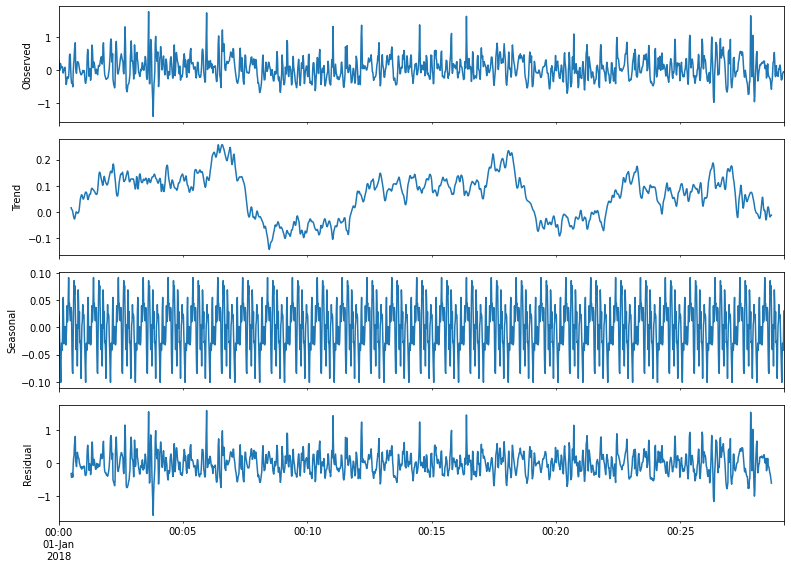

In [25]:
# Your code here:
matplotlib.rcParams['figure.figsize'] =11,8
decomposition = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], freq=60, model='additative')
fig =decomposition.plot()
plt.show()

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

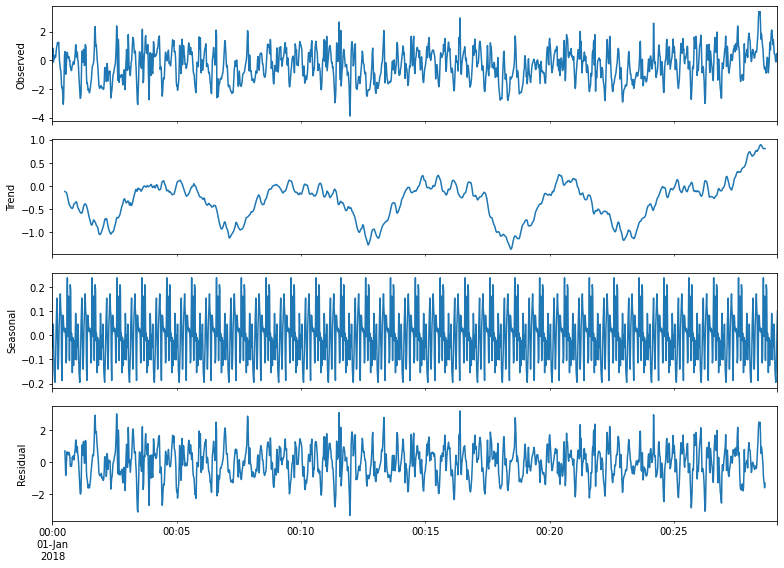

In [26]:
decomposition = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], freq=60, model='additative')
fig =decomposition.plot()
plt.show()

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

pandas.plotting.lag_plot(series, lag=1, ax=None, **kwds)

Lag plots are most commonly used to look for patterns in time series data.

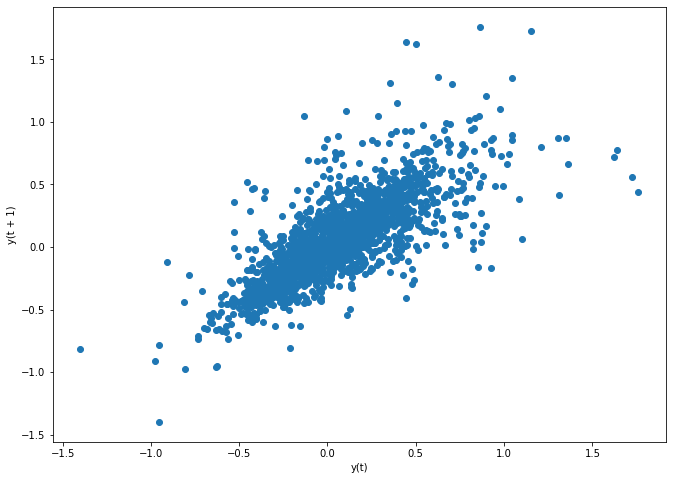

In [29]:
# Your code here:
#lag = 1 for default
pd.plotting.lag_plot(sensor['userAcceleration.x'])

Create a lag plot for `rotationRate.x`

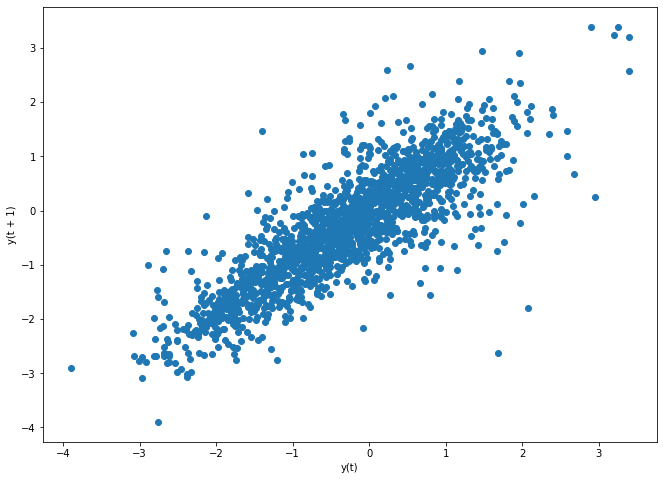

In [30]:
# Your code here:
#lag = 1 for default
pd.plotting.lag_plot(sensor['rotationRate.x'])

What are your conclusions from both visualizations?

If your data shows a linear pattern, it suggests autocorrelation is present. A positive linear trend (i.e. going upwards from left to right) is suggestive of positive autocorrelation; a negative linear trend (going downwards from left to right) is suggestive of negative autocorrelation. The tighter the data is clustered around the diagonal, the more autocorrelation is present; perfectly autocorrelated data will cluster in a single diagonal line.

In [32]:
# Your conclusions here:
#Both lag plots show a positive linear trend, suggesting a positive autocorrelation.

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

statsmodels.tsa.stattools.adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

Returns:

- adf(float): the test statistics
- pvalue(float)
- usedlag (int): number of lags used
- nobs (int): number of observations used for the ADF regression 
- critical values (dict): at the 1%, 5% and 10% levels
- icbest (float): maximized information criterion if autolag is not none
- resstore


In [35]:
# Your code here:
fuller_acceleration = adfuller(sensor['userAcceleration.x'])
fuller_acceleration

(-17.95799408616976,
 2.823439483037483e-30,
 4,
 1746,
 {'1%': -3.434100824760071,
  '10%': -2.5676520210882936,
  '5%': -2.863196780129223},
 -727.6140124402791)

In [36]:
fuller_acceleration = adfuller(sensor['rotationRate.x'])
fuller_acceleration

(-5.269860625086421,
 6.320230335912189e-06,
 25,
 1725,
 {'1%': -3.4341465551936534,
  '10%': -2.567662770090317,
  '5%': -2.863216966926812},
 2619.6049719981947)

What are your conclusions from this test?

In [ ]:
# Your conclusions here:
#H0: la serie de tiempo no es estacionaria
#pvalue: nuestro pvalue es menor a 0.05, por lo que podemos rechazar H0
#Conclusion: la serie de tiempo es estacionaria

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [40]:
# Your code here:
test_data = sensor['userAcceleration.x'][-10:]
train_data = sensor['userAcceleration.x'][:-10]

In [46]:
model = ARMA(train_data, order=(2,1))
result = model.fit()

predicciones = result.forecast(steps=10)[0]
predicciones

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


array([0.1731485 , 0.14289568, 0.10052195, 0.07010617, 0.0560991 ,
       0.05377815, 0.05679034, 0.06064627, 0.06331585, 0.06449343])

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [48]:
# Your code here:
rmse(test_data, predicciones)
#raíz cuadrada del error

0.22529863971115618